<a href="https://colab.research.google.com/github/chriswilson2020/PyTorchCoLab/blob/main/02_Neural_Network_Classification_With_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02. Neural Network classification with PyTorch

Classification is a problem of predicting wheter something is on thing or another (there can be multiple things as the options).

Book version of this notebook - https://www.learnpytorch.io/02_pytorch_classification/

All other resources - https://github.com/mrdbourke/pytorch-deep-learning

 ## 1. Make classification data and get it ready

In [1]:
import sklearn

In [2]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42) 

In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [5]:
# Make DataFram of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:,0],
                        "X2": X[:,1],
                        "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


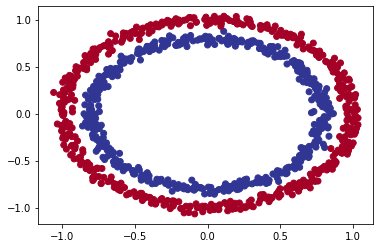

In [6]:
# Visulaise, visualise, visualise
import matplotlib.pyplot as plt

plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu);

Note: The data we're working with is often referred to as a toy dataset, a dataset that is small enough to experiment on but still sizeable enought to practice the fundamentals. 

Useful Resources for toy datasets - https://scikit-learn.org/stable/datasets/toy_dataset.html

### 1.1 Check input an output shapes



In [7]:
X.shape, y.shape

((1000, 2), (1000,))

In [8]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [9]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train and test splits

In [10]:
# imports
import torch
torch.__version__

'1.12.1+cu113'

In [11]:
type(X)

numpy.ndarray

In [12]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]), tensor([1., 1., 1., 1., 0.]))

In [13]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [14]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 0.2 = 20% of data will be test & 80% will be train
                                                    random_state=42)

In [15]:
print(f"The length of X_train: {len(X_train)} The length of X_test: {len(X_test)}\nThe length of y_train: {len(y_train)} The length of y_test: {len(y_test)}")

The length of X_train: 800 The length of X_test: 200
The length of y_train: 800 The length of y_test: 200


In [16]:
n_samples

1000

## 2. Building a model

Let's build a model to classify our bluw and red dots.

To do so, we want to:

1. Setup device agnostic code so our code will run on an accelerator (GPU) if there is one
2. Construct a model (by subclassing `nn.Module`)
3. Define the loss function and optimizer
4. Create a training and test loop


In [17]:
# Import PyTorch and nn
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [18]:
X_train

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        ...,
        [ 0.0157, -1.0300],
        [ 1.0110,  0.1680],
        [ 0.5578, -0.5709]])

Now we've setup device agnostic code, let's create a model that:

1. Subclasses `nn.module` (almost all models in PyTorch subclass `nn.Module`)
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our fata
3. Define a `forward()` method that outlines the forward pass (or forward computation) of the model
4. Instantiate an instance of our model class and send it to the target device

In [19]:
# 1. Construct a mdodel that subclasses nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2.0 Create 2 nn.Linear layers capable of handling the shapes of our data
    self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features and upscales to 5 features
    self.layer_2 = nn.Linear(in_features=2, out_features=1) # takes in 5 features from previous layer and outputs a single feature (same shape as y)

  # 3. Define a forward() method that outlines the forward pass
  def forward(self, x):
    return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output

# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0


CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=2, out_features=1, bias=True)
)

In [20]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [21]:
# Let's replicate the model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [22]:
model_0.state_dict()

OrderedDict([('0.weight', tensor([[ 0.3044, -0.1669],
                      [-0.6833, -0.3000],
                      [-0.1653, -0.1421],
                      [ 0.1493, -0.5823],
                      [-0.3832, -0.2906]], device='cuda:0')),
             ('0.bias',
              tensor([-0.5942,  0.1083, -0.4756, -0.6102, -0.6620], device='cuda:0')),
             ('1.weight',
              tensor([[-0.0835,  0.2942,  0.4095, -0.3590, -0.1136]], device='cuda:0')),
             ('1.bias', tensor([0.1898], device='cuda:0'))])

In [23]:
# Make Predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape of predictions: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n{torch.round(untrained_preds[:10])}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of predictions: 200, Shape of predictions: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.]], device='cuda:0')

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2,1 Setup loss function and optimizer

Which loss function or optimizer should you use?

Again... this is problem specific.

For example for regression you might want MAE or MSE (mean absolute error or mean squared error).
For classification you might want binary cross entropy or categorical cross entropy (cross entropy).

As a reminder, the loss function measures how wrong your predictions are.

And for optimizers, two of the most common and useful are SGD and Adam although PyTorch has many more.

* For some common choices of loss functions and optimizers - https://www.learnpytorch.io/02_pytorch_classification/#21-setup-loss-function-and-optimizer

* For the loss function we're going to use `torch.nn.BECWithLogitsLoss()`, for more on what binary cross entropy (BCE) is, check out this article - https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a

* For a definition on what a logit is in deep learning - https://stackoverflow.com/a/52111173/7900723

*For different optimizers see `torch.optim`


In [24]:
# Setup the loss function
#loss_fn = nn.BCELoss() # BCELoss = requires inputs to have gone through the sigmoid activation function prior to input

loss_fn = nn.BCEWithLogitsLoss() #BCEWithLogitsLoss = sigmoid activation function built in

optimizer =  torch.optim.SGD(params=model_0.parameters(),
                             lr=0.1)

In [25]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right?

def accuracy_fn(y_true, y_pred):
   correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
   acc = (correct / len(y_pred)) * 100 
   return acc

## 3. Train model

To train our model, we're going to need to build a training loop:

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward (backpropagation)
5. Optimizer step (gradient descent)

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**

We can convert these **logits** into prediction probabilities by passing them to some kind of activation function (e.g. sigmoid for binary classification and softmax for multiclass classification). 

Then we can convert our models prediction probabilities by **prediction labels** by either rounding them or taking the `argmax()`

In [26]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.5598],
        [0.4713],
        [0.5501],
        [0.5635],
        [0.1669]], device='cuda:0')

In [27]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [28]:
# Use the sigmoid activation function on our model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.6364],
        [0.6157],
        [0.6342],
        [0.6373],
        [0.5416]], device='cuda:0')

For our prediction probability values, we need to perform a range-style rounding on them:
* `y_pred_probs` >= 0.5, `y=1` (class 1)
* `y_pred_probs` < 0.5 `y=0` (class 0)


In [29]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 1., 1., 1.], device='cuda:0')

## 3.2 Building a training and testing loop

In [30]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop

for epoch in range(epochs):
  ### Training
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -pred labels

  # 2. Calculate loss/accuracy
  loss = loss_fn(y_logits, # nn.BCEWithLongitsLoss expects raw logits as input
                 y_train)
  
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)
  
  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backpropagation)
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

   ### Testing
  model_0.eval()
  with torch.inference_mode():
     # 1. Forward pass
     test_logits = model_0(X_test).squeeze()
     test_pred = torch.round(torch.sigmoid(test_logits))

     # 2. Calculate test loss/acc
     test_loss = loss_fn(test_logits,
                         y_test)
     test_acc = accuracy_fn(y_true=y_test,
                            y_pred=test_pred)
     
     # Print out what's happening
     if epoch % 10 == 0:
       print(f"Epoch: {epoch} | Loss: {loss:.5f}, | Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test_acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.71549, | Acc: 50.00% | Test loss: 0.71210, Test_acc: 50.00%
Epoch: 10 | Loss: 0.70146, | Acc: 53.50% | Test loss: 0.69902, Test_acc: 54.00%
Epoch: 20 | Loss: 0.69751, | Acc: 50.62% | Test loss: 0.69545, Test_acc: 56.50%
Epoch: 30 | Loss: 0.69607, | Acc: 49.88% | Test loss: 0.69435, Test_acc: 53.00%
Epoch: 40 | Loss: 0.69534, | Acc: 50.38% | Test loss: 0.69397, Test_acc: 51.50%
Epoch: 50 | Loss: 0.69485, | Acc: 50.50% | Test loss: 0.69383, Test_acc: 47.50%
Epoch: 60 | Loss: 0.69449, | Acc: 50.38% | Test loss: 0.69380, Test_acc: 50.00%
Epoch: 70 | Loss: 0.69420, | Acc: 50.25% | Test loss: 0.69381, Test_acc: 50.50%
Epoch: 80 | Loss: 0.69398, | Acc: 49.88% | Test loss: 0.69385, Test_acc: 51.50%
Epoch: 90 | Loss: 0.69379, | Acc: 49.75% | Test loss: 0.69391, Test_acc: 51.50%
Epoch: 100 | Loss: 0.69365, | Acc: 49.38% | Test loss: 0.69398, Test_acc: 54.00%
Epoch: 110 | Loss: 0.69353, | Acc: 49.12% | Test loss: 0.69405, Test_acc: 52.00%
Epoch: 120 | Loss: 0.69343, | Acc: 49.5

## 4. Make predictions and evaluate the model

From the metrics it looks like our model isn't leaarning anything...

So to inspect it let's make some preditions and make it visual

To do so, we're going to import a function called `plot_decision_boundary()`

In [31]:
import requests
from pathlib import Path

#Download helper functions from Learn PyTorch repo (if it's already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Download helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/chriswilson2020/PyTorchCoLab/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)
  
from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


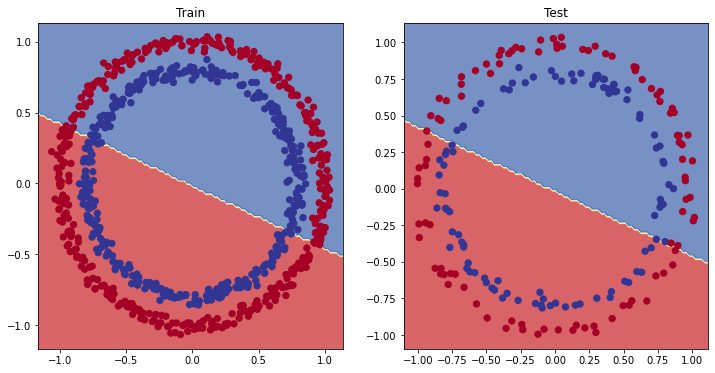

In [32]:
# Plot decision bondary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model perspective)

* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer
* Changing the activation functions
* Change the learning rate
* Change the loss function

These options are all from a model's perspective because they deal directly with the model, rather than the data.

And becuase these are options are all values we (as machine learning engineers and data scientists) can change they are refferd to as **hyperparameters**.

Let's try and improve our model by: 
* Adding more hidden units: 5 -> 10
* Increase the number of layers: 2 -> 3
* Increase the number of epochs: 100 -> 1000

In [33]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
  
  def forward(self, x):
  #z = self.layer_1(x)
  #z = self.layer_2(z)
  #z = self.layer_3(z)
    return self.layer_3(self.layer_2(self.layer_1(x))) # This way of writing operations leverages speedups where possible behind the scenes

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [34]:
model_1.state_dict()

OrderedDict([('layer_1.weight', tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984], device='cuda:0')),
             ('layer_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222, -0.2426,  0

In [35]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr = 0.01)

In [36]:
# Write a training and evaluation loop for model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop

for epoch in range(epochs):
  ### Training
  model_1.train()

  # 1. Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -pred labels

  # 2. Calculate loss/accuracy
  loss = loss_fn(y_logits, # nn.BCEWithLongitsLoss expects raw logits as input
                 y_train)
  
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)
  
  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backpropagation)
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

   ### Testing
  model_1.eval()
  with torch.inference_mode():
     # 1. Forward pass
     test_logits = model_1(X_test).squeeze()
     test_pred = torch.round(torch.sigmoid(test_logits))

     # 2. Calculate test loss/acc
     test_loss = loss_fn(test_logits,
                         y_test)
     test_acc = accuracy_fn(y_true=y_test,
                            y_pred=test_pred)
     
     # Print out what's happening
     if epoch % 100 == 0:
       print(f"Epoch: {epoch} | Loss: {loss:.5f}, | Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test_acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69396, | Acc: 50.88% | Test loss: 0.69261, Test_acc: 51.00%
Epoch: 100 | Loss: 0.69369, | Acc: 50.25% | Test loss: 0.69269, Test_acc: 50.00%
Epoch: 200 | Loss: 0.69351, | Acc: 50.12% | Test loss: 0.69282, Test_acc: 49.50%
Epoch: 300 | Loss: 0.69339, | Acc: 50.50% | Test loss: 0.69295, Test_acc: 49.00%
Epoch: 400 | Loss: 0.69329, | Acc: 50.38% | Test loss: 0.69309, Test_acc: 48.50%
Epoch: 500 | Loss: 0.69322, | Acc: 49.88% | Test loss: 0.69322, Test_acc: 49.50%
Epoch: 600 | Loss: 0.69317, | Acc: 49.50% | Test loss: 0.69335, Test_acc: 53.00%
Epoch: 700 | Loss: 0.69313, | Acc: 49.38% | Test loss: 0.69347, Test_acc: 50.50%
Epoch: 800 | Loss: 0.69309, | Acc: 50.00% | Test loss: 0.69358, Test_acc: 51.00%
Epoch: 900 | Loss: 0.69307, | Acc: 50.62% | Test loss: 0.69368, Test_acc: 47.50%


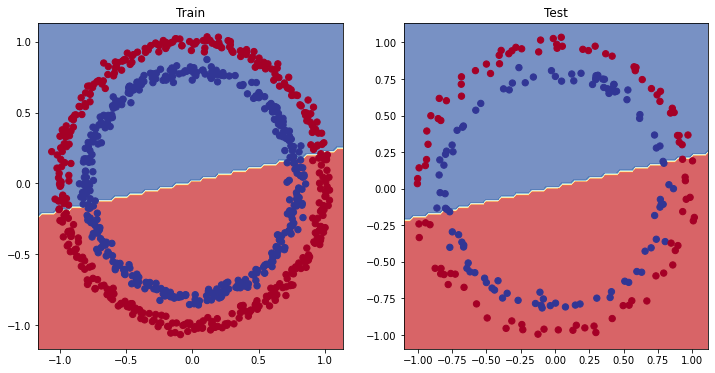

In [37]:
# Plot decision bondary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if our model can fit a straight line

One way to troubleshoot to a larger problem is to test out a smaller problem. 

In [38]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # Linear regression formula (without epsilon)

# Check the data
print(len(X_regression))
print(X_regression[:5], "\n\n", y_regression[:5])

100
tensor([[0.0000],
        [0.0100],
        [0.0200],
        [0.0300],
        [0.0400]]) 

 tensor([[0.3000],
        [0.3070],
        [0.3140],
        [0.3210],
        [0.3280]])


In [39]:
# Creat train and test splits
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

print(f"X training points: {len(X_train_regression)} X test points: {len(X_test_regression)} \n")
print(f"y training points: {len(y_train_regression)} y test points: {len(y_test_regression)}")

X training points: 80 X test points: 20 

y training points: 80 y test points: 20


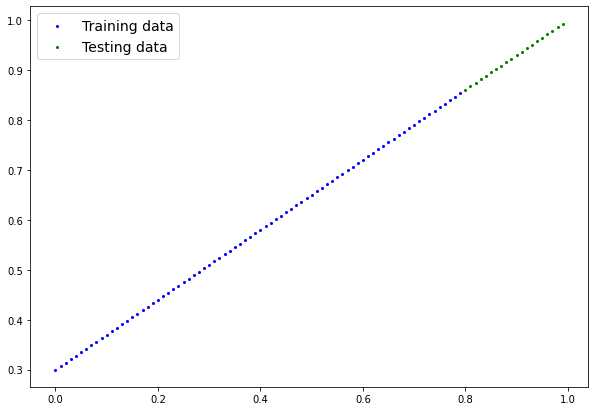

In [40]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression)

## 5.2 Adjusting `model_1` to fit a straight line

In [41]:
# Same architecture as model_1 (but using nn.Sequential())
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [44]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.01)

In [45]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#Set the number of epochs
epochs = 1000

# Put the data on the target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

#Training
for epoch in range(epochs):
  y_pred = model_2(X_train_regression) #Forward
  loss = loss_fn(y_pred, y_train_regression) #calculate the loss
  optimizer.zero_grad() # zero the gradient
  loss.backward() # Backpropagation
  optimizer.step() # Gradient descent

  # Testing
  model_2.eval()
  with torch.inference_mode():
   test_pred = model_2(X_test_regression)
   test_loss = loss_fn(test_pred, y_test_regression)

  # Print out whats happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.06466 | Test loss: 0.12597
Epoch: 100 | Loss: 0.00743 | Test loss: 0.00093
Epoch: 200 | Loss: 0.00621 | Test loss: 0.00123
Epoch: 300 | Loss: 0.00619 | Test loss: 0.00116
Epoch: 400 | Loss: 0.00617 | Test loss: 0.00094
Epoch: 500 | Loss: 0.00646 | Test loss: 0.00138
Epoch: 600 | Loss: 0.00614 | Test loss: 0.00110
Epoch: 700 | Loss: 0.00612 | Test loss: 0.00103
Epoch: 800 | Loss: 0.00641 | Test loss: 0.00149
Epoch: 900 | Loss: 0.00639 | Test loss: 0.00118


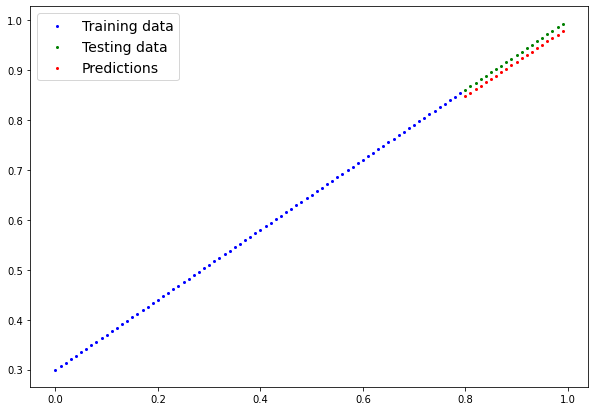

In [68]:
# Make some predictions and plot
model_2.eval()
with torch.inference_mode():
  y_preds = model_2(X_test_regression)

plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu());